In [1]:
# Fix root path
import sys
sys.path.append('..')

In [2]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from art.attacks.evasion import BasicIterativeMethod, FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from defences.region_based_classifier import RegionBasedClassifier
from defences.util import dataset2tensor, get_correct_examples
from models.torch_util import validate
from models.cifar10 import Resnet
from models.mnist import BaseModel

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [5]:
PATH_DATA = os.path.join('..', 'data')
PATH_RESULTS = os.path.join('..', 'results', 'mnist_base_model.pt')
BATCH_SIZE = 128
EPOCHS = 10
N_ADV = 2000

In [6]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.CIFAR10(PATH_DATA, train=True, download=True, transform=transforms)
dataset_test = datasets.CIFAR10(PATH_DATA, train=False, download=True, transform=transforms)

# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()
tensor_X_test, tensor_y_test = dataset2tensor(dataset_test)
X_test = tensor_X_test.cpu().detach().numpy()
y_test = tensor_y_test.cpu().detach().numpy()

# Split model training set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000)
dataset_train = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Check sizes
print(X_train.shape, X_val.shape, X_test.shape)

(45000, 3, 32, 32) (5000, 3, 32, 32) (10000, 3, 32, 32)


## Train point-based classifier

In [8]:
# Create Neural Network model
model = Resnet(use_prob=True)
model.to(device)
path_model = os.path.join('..', 'results', 'cifar10_resnet_200.pt')
model.load_state_dict(torch.load(path_model))

<All keys matched successfully>

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.CrossEntropyLoss()

## Remove missclassified samples

In [10]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss, device)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss, device)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 45000
Accuracy on 43657 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 8812 filtered test examples: 100.0000%


## Create adversarial examples 

In [11]:
X_benign = np.load(os.path.join('..', 'results', 'cifar10_resnet_cw2_0.0_x.npy'))
y_true = np.load(os.path.join('..', 'results', 'cifar10_resnet_cw2_0.0_y.npy'))
adv = np.load(os.path.join('..', 'results', 'cifar10_resnet_cw2_0.0_adv.npy'))
print(X_benign.shape, y_true.shape, adv.shape)

(2000, 3, 32, 32) (2000,) (2000, 3, 32, 32)


## Feature Squeezing

In [12]:
from defences.feature_squeezing import DepthSqueezer, MedianSqueezer, NLMeansColourSqueezer, FeatureSqueezingTorch

In [13]:
squeezers = []
squeezers.append(DepthSqueezer(x_min=0.0, x_max=1.0, bit_depth=4))
squeezers.append(MedianSqueezer(x_min=0.0, x_max=1.0, kernel_size=2))
squeezers.append(NLMeansColourSqueezer(x_min=0.0, x_max=1.0, h=2, templateWindowsSize=3, searchWindowSize=13))

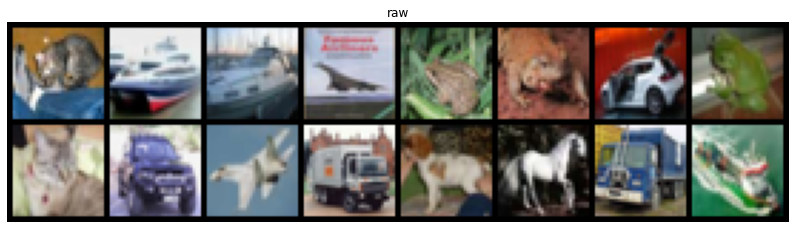

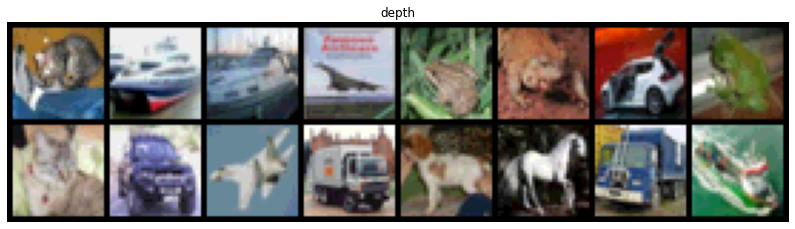

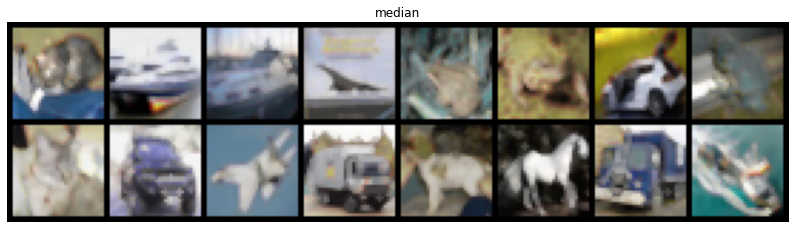

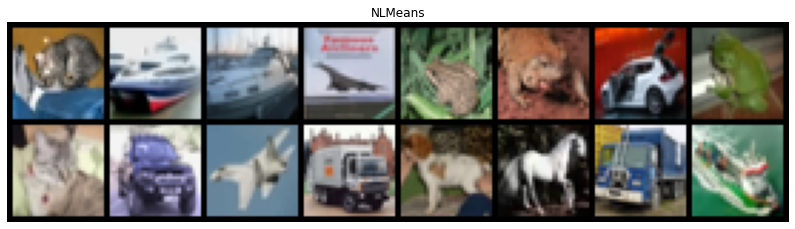

In [14]:
# Show squerzers' outputs
X_transformed = torch.from_numpy(X_test[:16])
grid_image = make_grid(X_transformed).permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(14, 4))
plt.imshow(grid_image)
plt.axis('off')
plt.title('raw')
plt.show()

for s in squeezers:
    X_transformed = s.transform(X_test[:16])
    X_transformed = torch.from_numpy(X_transformed)
    grid_image = make_grid(X_transformed).permute(1, 2, 0).detach().numpy()
    plt.figure(figsize=(14, 4))
    plt.imshow(grid_image)
    plt.axis('off')
    plt.title(s.name)
    plt.show()

In [15]:
fs = FeatureSqueezingTorch(
    classifier=model,
    lr=0.001,
    momentum=0.9,
    loss=loss,
    batch_size=128,
    x_min=0.0,
    x_max=1.0,
    squeezers=squeezers,
    n_classes=10,
    device=device)

In [18]:
fs.fit(X_train[:20000], y_train[:20000], epochs=EPOCHS, verbose=1)

Transforming depth...
Transforming median...
Transforming NLMeans...
Training depth...
 1/10 [0:00:13.936520] Squeezer: depth Train loss: 1.5041 acc: 95.9150%
 2/10 [0:00:14.007712] Squeezer: depth Train loss: 1.4966 acc: 96.6300%
 3/10 [0:00:14.029339] Squeezer: depth Train loss: 1.4934 acc: 96.9600%
 4/10 [0:00:14.033509] Squeezer: depth Train loss: 1.4897 acc: 97.3200%
 5/10 [0:00:13.988054] Squeezer: depth Train loss: 1.4872 acc: 97.5450%
 6/10 [0:00:14.005496] Squeezer: depth Train loss: 1.4852 acc: 97.7550%
 7/10 [0:00:14.006389] Squeezer: depth Train loss: 1.4834 acc: 97.9300%
 8/10 [0:00:14.009254] Squeezer: depth Train loss: 1.4829 acc: 97.9900%
 9/10 [0:00:13.962386] Squeezer: depth Train loss: 1.4827 acc: 97.9950%
10/10 [0:00:13.981870] Squeezer: depth Train loss: 1.4821 acc: 98.0700%
Training median...
 1/10 [0:00:14.038330] Squeezer: median Train loss: 1.5587 acc: 90.4450%
 2/10 [0:00:14.019870] Squeezer: median Train loss: 1.5339 acc: 92.9500%
 3/10 [0:00:14.189669] Squee

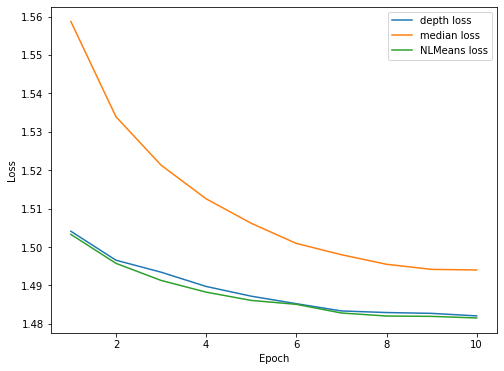

In [19]:
history_losses = fs.history_losses
n = len(history_losses[0])

plt.figure(figsize=(8, 6))
xx = np.arange(1, n+1)
for i in range(len(squeezers)):
    name = squeezers[i].name
    plt.plot(xx, history_losses[i], label='{} loss'.format(name))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Search threshold

In [22]:
fs.search_thresholds(X_benign[1000:], y_true[1000:], np.zeros(1000))

0.2501107186079009

## Testing FS on clean data

In [24]:
predictions = fs.predict(X_benign[:1000])
fp = np.mean(predictions==1) 
print('False postive rate: {:.4f}%'.format(fp*100))

False postive rate: 5.3667%


## Testing FS on Adversarial Examples

In [25]:
predictions = fs.predict(adv[:1000])
tp = np.mean(predictions==1)
print('True postive rate: {:.4f}%'.format(tp*100))

True postive rate: 94.7667%


## ROC AUC

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from defences.util import get_roc

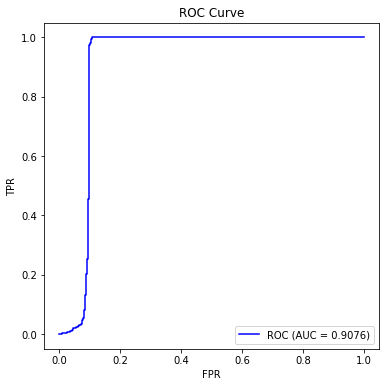

In [36]:
n = 1000
X_mixed = np.concatenate((adv[:n], X_benign[:n]))
label_adv = np.concatenate((np.ones_like(y_true[:n]), np.zeros_like(y_true[:n])))
y_true_mixed = np.concatenate((y_true[:100], y_true[:n]))

detected_as_adv_proba = fs.predict_proba(X_mixed)
_, _, auc_score, _ = get_roc(label_adv, detected_as_adv_proba, show_plot=True)

## Accuracy on Adversarial Examples

In [39]:
from defences.util import acc_on_adv
from models.torch_util import predict_numpy

In [40]:
y_pred = predict_numpy(model, adv[:n], device)
detected_as_adv = fs.detect(adv[:n])
acc_on_adv(y_pred, y_true[:n], detected_as_adv)

1.0